In [5]:
import numpy as np
import numpy_financial as npf
import pandas as pd
from scipy.stats import weibull_min, uniform
import matplotlib.pyplot as plt
import seaborn as sns
import model_functions as func

In [6]:
# Indlæs befolkningsdata 1950-2023, alle lande, 1-års intervaller
befolkning = pd.read_excel("./populationsdata/WPP2024_POP_F01_1_POPULATION_SINGLE_AGE_BOTH_SEXES.xlsx", header=16)
befolkning = befolkning.loc[befolkning.Type == "Country/Area"].reset_index()
iso_to_reg = pd.read_csv("./populationsdata/iso_to_region.csv")
befolkning = befolkning.merge(
    iso_to_reg[['alpha-3', 'region']], 
    left_on='ISO3 Alpha-code',
    right_on='alpha-3',
    how='left'
)

# Check the number of countries and years
print(f"Number of countries: {befolkning['ISO3 Alpha-code'].nunique()}")
print(f"Number of years: {befolkning['Year'].nunique()}")

# Additional checks
print(f"Number of rows: {befolkning.shape[0]}")
print(f"Number of columns: {befolkning.shape[1]}")

# indlæs HDI data 1990 - 2023 
hdi = pd.read_csv("./populationsdata/HDR23-24_Composite_indices_complete_time_series.csv", encoding='latin1')

Number of countries: 237
Number of years: 74
Number of rows: 17538
Number of columns: 115


In [7]:
# Get list of HDI columns for years 1990-2023
hdi_cols = [f'hdi_{year}' for year in range(1990, 2023)]

# Select iso3 column and all HDI columns
hdi = hdi[['iso3'] + hdi_cols]

# Merge HDI data with population data
befolkning = befolkning.merge(hdi, left_on='ISO3 Alpha-code', right_on='iso3', how='left')

# First, let's see what columns we actually have in the HDI data
print("HDI columns:")
print(hdi.columns.tolist())

# Then adjust the HDI columns list based on actual column names
# For example, if the columns are named like 'HDI_1990' instead of 'hdi_1990':
hdi_cols = [col for col in hdi.columns if col.startswith('HDI_') or col.startswith('hdi_')]

# Now proceed with the merging and filling
for col in hdi_cols:
    # Calculate regional means for current HDI year, excluding NaN values
    regional_means = befolkning.groupby('region')[col].mean()
    print(f"\nRegional averages for {col}:")
    print(regional_means)
    
    # For each region, fill NaN values with that region's mean
    for region in befolkning['region'].dropna().unique():
        region_mask = befolkning['region'] == region
        region_mean = regional_means[region]
        befolkning.loc[region_mask, col] = befolkning.loc[region_mask, col].fillna(region_mean)

HDI columns:
['iso3', 'hdi_1990', 'hdi_1991', 'hdi_1992', 'hdi_1993', 'hdi_1994', 'hdi_1995', 'hdi_1996', 'hdi_1997', 'hdi_1998', 'hdi_1999', 'hdi_2000', 'hdi_2001', 'hdi_2002', 'hdi_2003', 'hdi_2004', 'hdi_2005', 'hdi_2006', 'hdi_2007', 'hdi_2008', 'hdi_2009', 'hdi_2010', 'hdi_2011', 'hdi_2012', 'hdi_2013', 'hdi_2014', 'hdi_2015', 'hdi_2016', 'hdi_2017', 'hdi_2018', 'hdi_2019', 'hdi_2020', 'hdi_2021', 'hdi_2022']

Regional averages for hdi_1990:
region
Africa      0.434811
Americas    0.636621
Asia        0.589658
Europe      0.769250
Oceania     0.650667
Name: hdi_1990, dtype: float64

Regional averages for hdi_1991:
region
Africa      0.437162
Americas    0.640517
Asia        0.592605
Europe      0.770625
Oceania     0.655000
Name: hdi_1991, dtype: float64

Regional averages for hdi_1992:
region
Africa      0.437378
Americas    0.645379
Asia        0.596684
Europe      0.771281
Oceania     0.659167
Name: hdi_1992, dtype: float64

Regional averages for hdi_1993:
region
Africa      0.

In [27]:
# Opsæt simuleringsparametre
simuleringparametre = {
    'præklinisk_succes_sandsynlighed': 0.85,  # Højere for sjældne genterapi
    'præklinisk_omkostningsinterval': (0.8e6, 2e6),  # Forskningsgrad AAV produktion + studier
    'præklinisk_tidsinterval': (1, 2),
    
    'fase12_succes_sandsynlighed': 0.82,  # Kombineret fase 1/2 succesrate for sjælden genterapi
    'fase12_omkostningsinterval': (3e6, 6e6),  # 9 patienter × $200K + vektor + overhead
    'fase12_tidsinterval': (1.5, 2.5),
    
    'fase3_succes_sandsynlighed': 0.90,  # Høj for sjælden genterapi
    'fase3_omkostningsinterval': (10e6, 20e6),  # Realistisk for 25-patient studie
    'fase3_tidsinterval': (2, 3),
    
    'godkendelse_succes_sandsynlighed': 0.95,  # NDA/BLA til godkendelse
    'godkendelse_omkostningsinterval': (2e6, 5e6),
    'godkendelse_tidsinterval': (0.5, 1),
    
    'markedspenetration': func.triangular_distribution(0.3, 0.4, 0.5),  # Begrænset til 50%
    'pris': func.triangular_distribution(0.85e6, 2.1e6, 3.5e6),  # Baseret på godkendte genterapier
    
    'odd_fordele': {
        'gebyr_fritagelser': 3.5e6,  # PDUFA + BLA gebyrfritagelser (~3.5M USD i 2024)
        'skattefradrag': 0.25,  # 25% skattefradrag på kliniske forsøgsomkostninger
        'forskningstilskud': {
            'beløb': func.triangular_distribution(1.0e6, 2.6e6, 3.4e6),  # Baseret på 2024 OOPD tilskud
            'sandsynlighed': 0.15,  # Ca. 7-8 tilskud ud af 50+ ansøgninger årligt
            'varighed': 4  # Standard tilskudsperiode i år
        },
        'sandsynlighed': 0.95,  # Høj sandsynlighed for at opnå ODD for sjældne sygdomme
        'timing': {
            'fase12': 1,  # Skattefradrag modtages 1 år efter Fase 1/2 omkostninger
            'fase3': 1,    # Skattefradrag modtages 1 år efter Fase 3 omkostninger
            'godkendelse': 0  # Gebyrfritagelser anvendes med det samme ved godkendelse
        }
    },
    'prv_value': func.triangular_distribution(50e6, 100e6, 200e6),
    'rpdd_probability': 0.90,
    
    'adoptionsparametre': {
        'us': {
            'maks_adoption': uniform(0.2, 0.3).rvs(),
            'forsinkelse': uniform(2, 4).rvs(),
            'hastighed': uniform(0.3, 0.7).rvs()
        },
        'eu': {
            'maks_adoption': uniform(0.15, 0.25).rvs(),
            'forsinkelse': uniform(3, 5).rvs(),
            'hastighed': uniform(0.2, 0.5).rvs()
        }
    },
    
    'produktionsomkostning': func.triangular_distribution(1e5, 3e5, 5e5),
    'kommercialiseringsår': 5,
    'diskonteringsrente': 0.25,
    
    'risikofaktorer': {
        'præklinisk': [0.85],
        'fase12': [0.80],  # Updated to match combined phase 1/2
        'fase3': [0.65],
        'godkendt': [0.25, 0.20, 0.15, 0.10, 0.05]
    }
}

In [60]:
def calculate_survival_probability(age, median_survival=30, shape=2):
    """
    Calculate survival probability using Weibull distribution.
    Should be highest at age 0 and decrease with age.
    """
    if age >= 60:
        return 0
        
    # Use complementary Weibull CDF for survival probability
    # This gives probability of surviving TO this age
    return weibull_min.sf(age, shape, loc=0, 
                         scale=median_survival/(np.log(2)**(1/shape)))

def calculate_annual_mortality(age, median_survival=30, shape=2):
    """
    Calculate probability of dying during the next year at given age.
    Uses ratio of survival probabilities between current age and next age.
    """
    if age >= 60:
        return 1.0
        
    current_survival = calculate_survival_probability(age)
    next_survival = calculate_survival_probability(age + 1)
    
    # Probability of dying this year = 1 - P(survive this year)
    # P(survive this year) = P(survive to age+1) / P(survive to age)
    annual_mortality = 1 - (next_survival / current_survival) if current_survival > 0 else 1.0
    
    return max(0, min(1, annual_mortality))

In [81]:
land_data = befolkning[befolkning['ISO3 Alpha-code'] == "DNK"]
region = land_data['region'].iloc[0]

# Process each year
for år in range(1950, 2100):
# Get births for this year
    year_data = land_data[land_data['Year'] == år]
    if not year_data.empty:
        fødsler = year_data.iloc[0][0]  # Age 0 column
        
        # Generate new cases
        if fødsler > 0:
            antal_cases = np.random.binomial(int(fødsler), 1/500000)
            print(antal_cases)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [70]:
def lowe_syndrom_fremskrivning(befolkningsdata, prævalens, maks_levetid):
    """
    Fremskriver Lowe Syndrom-populationen fra 1950 til 2100 for alle lande.
    Antager diagnose ved fødsel og følger hver patient år for år.
    
    Parametre:
    - befolkningsdata: DataFrame med befolkningstal per land/år med aldre som kolonner
    - prævalens: Sygdommens prævalens (fx 1/500000)
    - maks_levetid: Maksimal levealder for patienter
    """
    patient_records = []
    
    # Process each country
    for land in befolkningsdata['ISO3 Alpha-code'].unique():
        print(f"\nBehandler land: {land}")
        nuværende_id = 0
        land_data = befolkningsdata[befolkningsdata['ISO3 Alpha-code'] == land]
        region = land_data['region'].iloc[0]
        
        # Process each year
        for år in range(1950, 2100):
            # Get births for this year
            year_data = land_data[land_data['Year'] == år]
            if not year_data.empty:
                fødsler = year_data.iloc[0][0]  # Age 0 column
                
                # Generate new cases
                if fødsler > 0:
                    antal_cases = np.random.binomial(int(fødsler), prævalens)
                    
                    # Create records for new patients
                    for _ in range(antal_cases):
                        patient_id = f"{land}_{nuværende_id}"
                        birth_year = år
                        nuværende_id += 1
                        
                        # Follow patient through the years
                        alder = 0
                        current_year = birth_year
                        while alder < maks_levetid and current_year < 2100:
                            dødelighed = calculate_annual_mortality(alder)
                            if np.random.random() > dødelighed:
                                patient_records.append({
                                    'patient_id': patient_id,
                                    'year': current_year,
                                    'age': alder,
                                    'birth_year': birth_year,
                                    'country': land,
                                    'region': region
                                })
                                alder += 1
                                current_year += 1
                            else:
                                break  # Patient died
    
    # Convert to DataFrame and sort
    df = pd.DataFrame(patient_records)
    return df.sort_values(['country', 'patient_id', 'year'])

In [71]:
befolkning_frem =lowe_syndrom_fremskrivning(befolkning, prævalens=1/500000, maks_levetid=40)


Behandler land: BDI

Behandler land: COM

Behandler land: DJI

Behandler land: ERI

Behandler land: ETH

Behandler land: KEN

Behandler land: MDG

Behandler land: MWI

Behandler land: MUS

Behandler land: MYT

Behandler land: MOZ

Behandler land: REU

Behandler land: RWA

Behandler land: SYC

Behandler land: SOM

Behandler land: SSD

Behandler land: UGA

Behandler land: TZA

Behandler land: ZMB

Behandler land: ZWE

Behandler land: AGO

Behandler land: CMR

Behandler land: CAF

Behandler land: TCD

Behandler land: COG

Behandler land: COD

Behandler land: GNQ

Behandler land: GAB

Behandler land: STP

Behandler land: DZA

Behandler land: EGY

Behandler land: LBY

Behandler land: MAR

Behandler land: SDN

Behandler land: TUN

Behandler land: ESH

Behandler land: BWA

Behandler land: SWZ

Behandler land: LSO

Behandler land: NAM

Behandler land: ZAF

Behandler land: BEN

Behandler land: BFA

Behandler land: CPV

Behandler land: CIV

Behandler land: GMB

Behandler land: GHA

Behandler la

In [76]:
befolkning_frem.country.value_counts()

CHN    134
IND     71
NLD     40
BGD     34
MEX     30
PHL     28
RUS     25
IDN     24
DEU     20
NGA      4
Name: country, dtype: int64

In [4]:
# Kør befolkningsfremskrivning
lowe_syndrom_data = func.lowe_syndrom_fremskrivning(
    befolkning, ['Europe', 'Americas'], prævalens=1/500000, maks_levetid=40, form=2, skala=15
)


Behandler region: Europe
Initial population oprettet: 1488 patienter
Total population ved udgangen af 2023: 1488
Overlevelsesrate: 97.6%
Total population ved udgangen af 2024: 1460
Overlevelsesrate: 97.9%
Total population ved udgangen af 2025: 1438
Overlevelsesrate: 97.4%
Total population ved udgangen af 2026: 1408
Overlevelsesrate: 97.9%
Total population ved udgangen af 2027: 1386
Overlevelsesrate: 97.6%
Total population ved udgangen af 2028: 1360
Overlevelsesrate: 97.0%
Total population ved udgangen af 2029: 1327
Overlevelsesrate: 96.8%
Total population ved udgangen af 2030: 1292
Overlevelsesrate: 96.7%
Total population ved udgangen af 2031: 1256
Overlevelsesrate: 97.5%
Total population ved udgangen af 2032: 1231
Overlevelsesrate: 96.7%
Total population ved udgangen af 2033: 1195
Overlevelsesrate: 96.0%
Total population ved udgangen af 2034: 1151
Overlevelsesrate: 97.1%
Total population ved udgangen af 2035: 1123
Overlevelsesrate: 95.9%
Total population ved udgangen af 2036: 1081
Ov

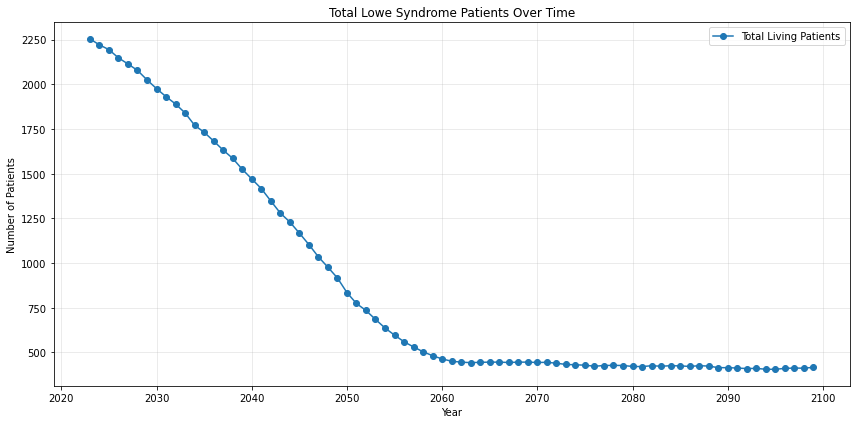


Yearly Patient Totals:
    year  total_patients
0   2023            2254
1   2024            2221
2   2025            2194
3   2026            2148
4   2027            2114
..   ...             ...
72  2095             406
73  2096             411
74  2097             413
75  2098             412
76  2099             417

[77 rows x 2 columns]


In [5]:
# Count total patients alive in each year
yearly_totals = (lowe_syndrom_data.groupby('year')
                   .size()
                   .reset_index(name='total_patients')
                   .sort_values('year'))

# Create the visualization
plt.figure(figsize=(12, 6))
plt.plot(yearly_totals['year'], 
         yearly_totals['total_patients'], 
         marker='o', 
         color='tab:blue', 
         label='Total Living Patients')

plt.xlabel('Year')
plt.ylabel('Number of Patients')
plt.title('Total Lowe Syndrome Patients Over Time')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Print the data
print("\nYearly Patient Totals:")
print(yearly_totals)

<AxesSubplot:xlabel='age'>

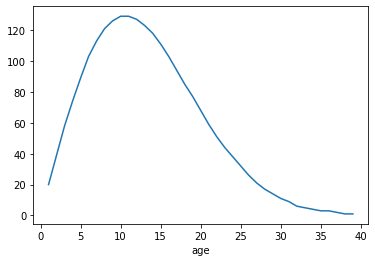

In [10]:
lowe_syndrom_data.loc[lowe_syndrom_data.year==2023].groupby("age").count().patient_id.plot()

In [8]:
# Kør Monte Carlo-simulation
antal_simuleringer = 10000
resultater, alle_patienter, alle_behandlede_patienter = func.monte_carlo_simulation(antal_simuleringer, lowe_syndrom_data, simuleringsparametre)


In [9]:
# Analyser og visualiser resultater
df_resultater = pd.DataFrame(resultater)
df_resultater = df_resultater.replace([np.inf, -np.inf], np.nan)
print("Sammenfatning af resultater:")
print(df_resultater.describe().round())

Sammenfatning af resultater:
       præklinisk_npv   fase12_npv    fase3_npv  godkendt_npv  præklinisk_roi  \
count          5913.0       5913.0       5913.0        5913.0          5913.0   
mean       74683941.0   94739372.0  122928589.0   167824773.0            71.0   
std         2291085.0    2768608.0    3270220.0     1721172.0            66.0   
min        66201690.0   84033205.0  110772378.0   159785775.0            33.0   
25%        73123683.0   92798441.0  120646077.0   167135107.0            44.0   
50%        74772092.0   94864665.0  123021174.0   168026141.0            56.0   
75%        76369169.0   96805266.0  125488219.0   168881170.0            74.0   
max        81356179.0  102416678.0  130926663.0   171922909.0           727.0   

       fase12_roi  fase3_roi  godkendt_roi  præklinisk_omkostninger  \
count      5913.0     5913.0        5913.0                   5913.0   
mean         16.0        6.0           7.0                1401434.0   
std           4.0        1.0

In [10]:
# Beregn gennemsnitsværdier for hver fase
gennemsnit_værdier = {
    'Præklinisk NPV': np.nanmean(df_resultater['præklinisk_npv']),
    'Fase 1/2 NPV': np.nanmean(df_resultater['fase12_npv']),
    'Fase 3 NPV': np.nanmean(df_resultater['fase3_npv']),
    'Godkendt NPV': np.nanmean(df_resultater['godkendt_npv'])
}
print("\nGennemsnitlige risikojusterede NPV-værdier for hver fase:")
for fase, værdi in gennemsnit_værdier.items():
    print(f"{fase}: {værdi:,.2f} kr")


Gennemsnitlige risikojusterede NPV-værdier for hver fase:
Præklinisk NPV: 74,683,941.11 kr
Fase 1/2 NPV: 94,739,372.09 kr
Fase 3 NPV: 122,928,589.34 kr
Godkendt NPV: 167,824,773.25 kr


In [11]:
# Beregn gennemsnitlige ROI-værdier for hver fase
gennemsnit_roi = {
    'Præklinisk ROI': np.mean(df_resultater['præklinisk_roi']),
    'Fase 1/2 ROI': np.mean(df_resultater['fase12_roi']),
    'Fase 3 ROI': np.mean(df_resultater['fase3_roi']),
    'Godkendt ROI': np.mean(df_resultater['godkendt_roi'])
}

print("\nGennemsnitlige ROI-værdier for hver fase:")
for fase, værdi in gennemsnit_roi.items():
    print(f"{fase}: {værdi:.2f}%")


Gennemsnitlige ROI-værdier for hver fase:
Præklinisk ROI: 70.99%
Fase 1/2 ROI: 16.34%
Fase 3 ROI: 5.98%
Godkendt ROI: 7.25%


In [12]:
# Beregn gennemsnitlige omkostninger og omsætning
gns_omkostninger = np.mean(df_resultater['totale_omkostninger'])
gns_omsætning = np.mean(df_resultater['total_omsætning'])

print(f"\nGennemsnitlige totale omkostninger: {gns_omkostninger:,.2f} kr")
print(f"Gennemsnitlig total omsætning: {gns_omsætning:,.2f} kr")


Gennemsnitlige totale omkostninger: 102,233,122.55 kr
Gennemsnitlig total omsætning: 420,289,775.86 kr


In [13]:
# Beregn gennemsnitlig burn rate
gns_burn_rate = np.mean(df_resultater['burn_rate'])
print(f"\nGennemsnitlig burn rate: {gns_burn_rate:,.2f} kr/år")


Gennemsnitlig burn rate: 3,634,224.46 kr/år


In [14]:
# Beregn gennemsnitlig udviklingstid
gns_udviklingstid = np.mean(df_resultater['samlet_tid'])
print(f"Gennemsnitlig udviklingstid: {gns_udviklingstid:.2f} år")

Gennemsnitlig udviklingstid: 6.75 år


In [15]:
# Scenarieanalyse
print("\nScenarie analyse:")
scenarier = ['Optimistisk', 'Base case', 'Pessimistisk']
percentiler = [75, 50, 25]
faser = ['præklinisk', 'fase12', 'fase3', 'godkendelse']

for scenarie, percentil in zip(scenarier, percentiler):
    print(f"{scenarie} scenarie:")
    npv = np.percentile(df_resultater['godkendt_npv'], percentil)
    print(f"  NPV: {npv:,.2f} kr")
    
    for fase in faser:
        # Calculate cumulative investment up to this phase
        fase_omkostninger = sum([np.percentile(df_resultater[f'{f}_omkostninger'], percentil) for f in faser[:faser.index(fase)+1]])
        
        # Calculate ROI: For every $1 invested up to this phase, how much do you get back?
        if fase_omkostninger > 0:
            roi = npv / fase_omkostninger
            print(f"  ROI {fase}: ${roi:.2f} (For every $1 invested up to {fase})")
        else:
            print(f"  ROI {fase}: N/A (No investment made)")

    print()  # A


Scenarie analyse:
Optimistisk scenarie:
  NPV: 168,881,169.58 kr
  ROI præklinisk: $98.95 (For every $1 invested up to præklinisk)
  ROI fase12: $24.23 (For every $1 invested up to fase12)
  ROI fase3: $6.89 (For every $1 invested up to fase3)
  ROI godkendelse: $5.87 (For every $1 invested up to godkendelse)

Base case scenarie:
  NPV: 168,026,140.58 kr
  ROI præklinisk: $119.42 (For every $1 invested up to præklinisk)
  ROI fase12: $28.52 (For every $1 invested up to fase12)
  ROI fase3: $8.07 (For every $1 invested up to fase3)
  ROI godkendelse: $6.91 (For every $1 invested up to godkendelse)

Pessimistisk scenarie:
  NPV: 167,135,107.10 kr
  ROI præklinisk: $151.75 (For every $1 invested up to præklinisk)
  ROI fase12: $34.57 (For every $1 invested up to fase12)
  ROI fase3: $9.65 (For every $1 invested up to fase3)
  ROI godkendelse: $8.33 (For every $1 invested up to godkendelse)



In [16]:
# Scenarieanalyse
print("\nScenarie analyse:")
scenarier = ['Optimistisk', 'Base case', 'Pessimistisk']
percentiler = [75, 50, 25]

for scenarie, percentil in zip(scenarier, percentiler):
    npv = np.percentile(df_resultater['godkendt_npv'], percentil)
    roi = np.percentile(df_resultater['godkendt_roi'], percentil)
    print(f"{scenarie} scenarie:")
    print(f"  NPV: {npv:,.2f} kr")
    print(f"  ROI: {roi:.2f}%")


Scenarie analyse:
Optimistisk scenarie:
  NPV: 168,881,169.58 kr
  ROI: 8.19%
Base case scenarie:
  NPV: 168,026,140.58 kr
  ROI: 7.06%
Pessimistisk scenarie:
  NPV: 167,135,107.10 kr
  ROI: 6.15%


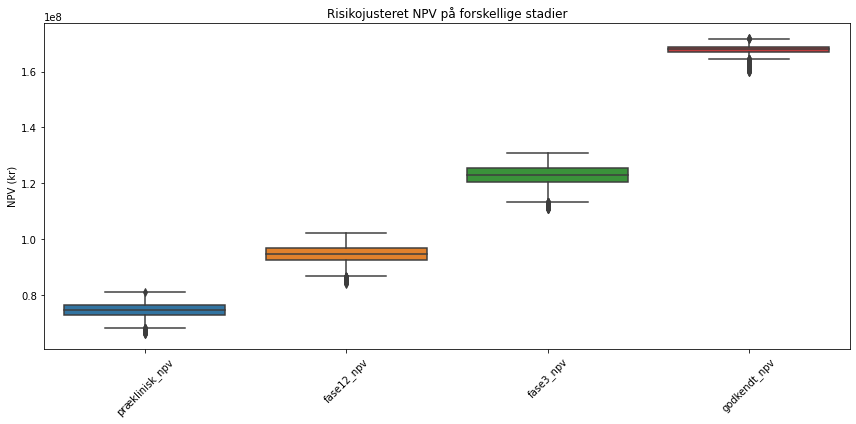

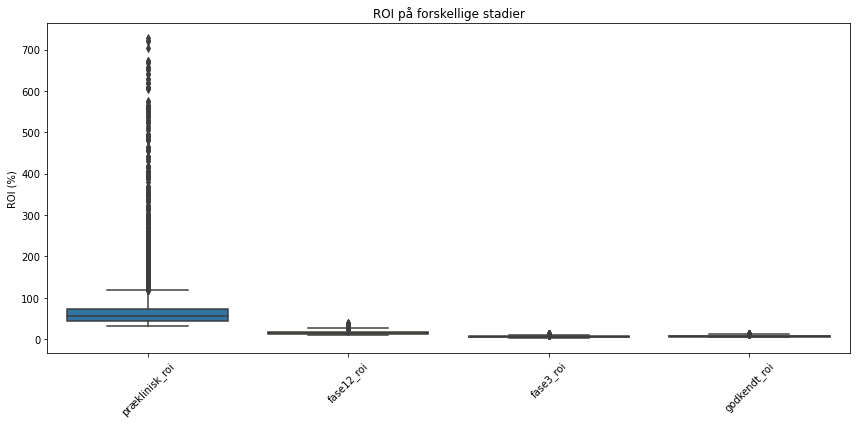

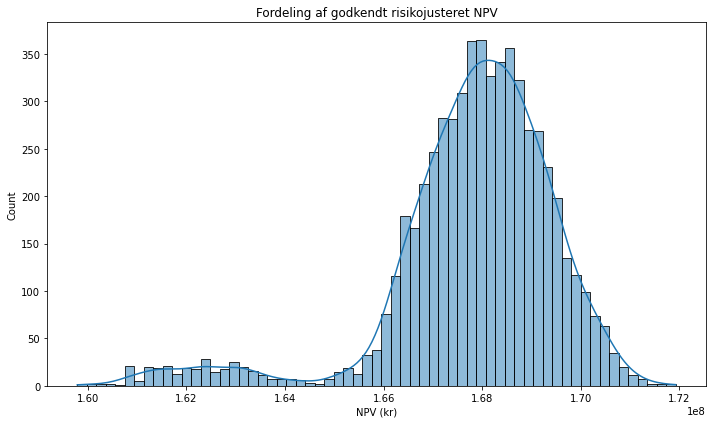

In [17]:
# Visualiseringer
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_resultater[['præklinisk_npv', 'fase12_npv', 'fase3_npv', 'godkendt_npv']])
plt.title('Risikojusteret NPV på forskellige stadier')
plt.ylabel('NPV (kr)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_resultater[['præklinisk_roi', 'fase12_roi', 'fase3_roi', 'godkendt_roi']])
plt.title('ROI på forskellige stadier')
plt.ylabel('ROI (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data=df_resultater, x='godkendt_npv', kde=True)
plt.title('Fordeling af godkendt risikojusteret NPV')
plt.xlabel('NPV (kr)')
plt.tight_layout()
plt.show()

In [18]:
# Beregn succesrate for hele udviklingsprocessen
succesfulde_simuleringer = len(df_resultater)
samlet_succesrate = succesfulde_simuleringer / antal_simuleringer

print(f"\nSamlet succesrate for udviklingsprocessen: {samlet_succesrate:.2%}")



Samlet succesrate for udviklingsprocessen: 59.13%


In [19]:
# Beregn forventet værdi af projektet
forventet_værdi = np.mean(df_resultater['godkendt_npv']) * samlet_succesrate
print(f"\nForventet værdi af projektet: {forventet_værdi:,.2f} kr")


Forventet værdi af projektet: 99,234,788.42 kr


In [21]:
# Beregn break-even tid
kumulativ_pengestrøm = np.cumsum([-gns_omkostninger] + [gns_omsætning / simuleringsparametre['kommercialiseringsår']] * simuleringsparametre['kommercialiseringsår'])
break_even_tid = np.argmax(kumulativ_pengestrøm >= 0) + gns_udviklingstid
print(f"Forventet break-even tid: {break_even_tid:.2f} år efter projektstart")


Forventet break-even tid: 7.76 år efter projektstart


In [25]:
dkk_rate = 6.8
print("\nEstimeret investeringsbehov for hver fase (DKK):")
print(f"Præklinisk: {np.mean(df_resultater['præklinisk_omkostninger']) * dkk_rate:,.2f} kr")
print(f"Fase 1/2: {np.mean(df_resultater['fase12_omkostninger']) * dkk_rate:,.2f} kr")
print(f"Fase 3: {np.mean(df_resultater['fase3_omkostninger']) * dkk_rate:,.2f} kr")
print(f"Godkendelse: {np.mean(df_resultater['godkendelse_omkostninger']) * dkk_rate:,.2f} kr")

print(f"\nTotal investeringsbehov: {total_investment:,.2f} kr")


Estimeret investeringsbehov for hver fase (DKK):
Præklinisk: 4,060,372.05 kr
Fase 1/2: 30,716,305.80 kr
Fase 3: 101,796,227.81 kr
Godkendelse: 23,846,864.08 kr

Total investeringsbehov: 109,720,833.96 kr


In [26]:
odd_success_rate = df_resultater['odd_obtained'].mean()
rpdd_success_rate = df_resultater['rpdd_obtained'].mean()

print(f"Orphan Drug Designation obtained in {odd_success_rate:.2%} of simulations")
print(f"Rare Pediatric Disease Designation obtained in {rpdd_success_rate:.2%} of simulations")

prv_values = df_resultater[df_resultater['prv_value'] > 0]['prv_value']
if not prv_values.empty:
    avg_prv_value = np.nanmean(prv_values)
    print(f"Average PRV value when obtained: {avg_prv_value:,.2f} $")
else:
    print("No PRV values were obtained in the simulations")

Orphan Drug Designation obtained in 94.84% of simulations
Rare Pediatric Disease Designation obtained in 90.54% of simulations
No PRV values were obtained in the simulations


In [29]:
np.sum(gennemsnit_behandlede)

289.0126813689713

In [28]:
gennemsnit_patienter

array([1147.05726725, 1147.05726725, 1147.05726725, 1147.05726725,
       1147.05726725])

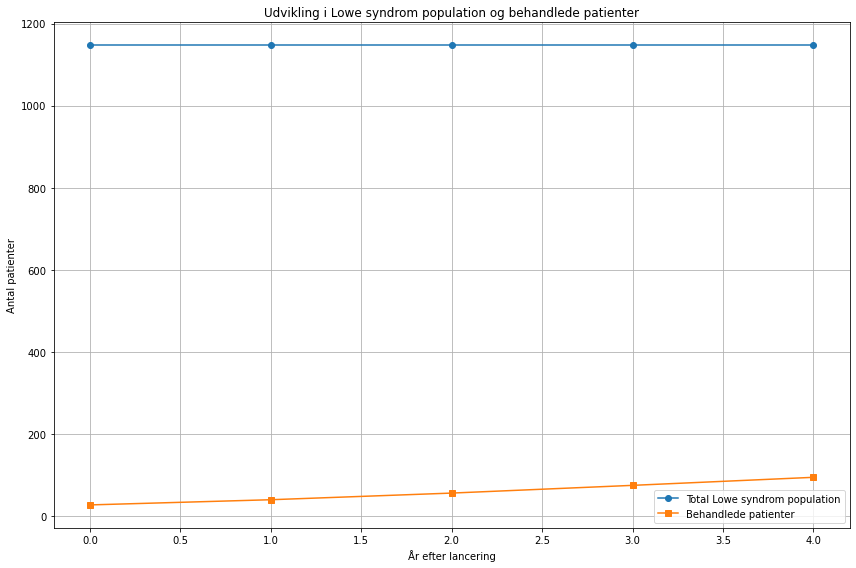

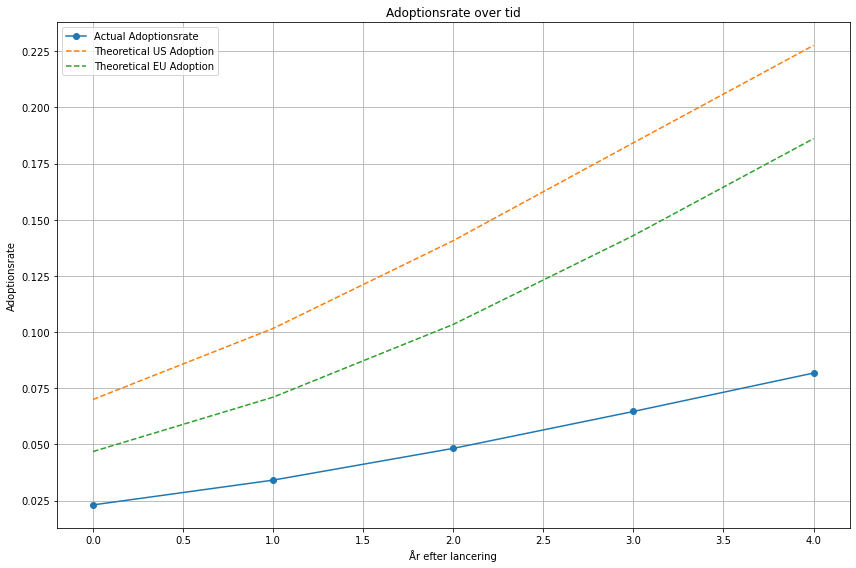

In [27]:

# Beregn gennemsnit af patient data
gennemsnit_patienter = np.mean(alle_patienter, axis=0)
gennemsnit_behandlede = np.mean(alle_behandlede_patienter, axis=0)

# Plot patient adoption
func.plot_patient_adoption(gennemsnit_patienter, gennemsnit_behandlede, simuleringsparametre['adoptionsparametre'], simuleringsparametre['kommercialiseringsår'])


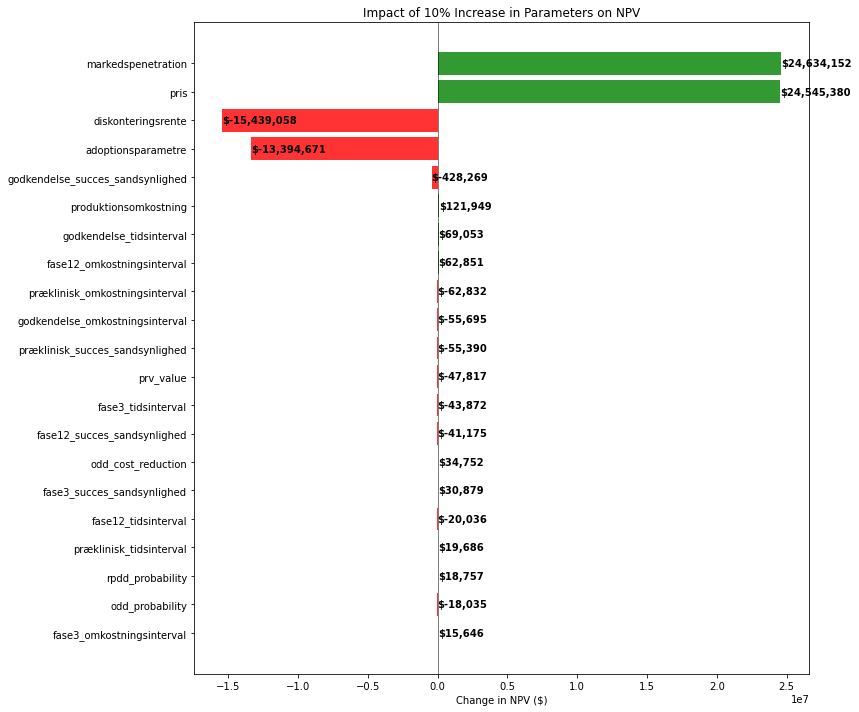

In [30]:

# Run the analysis
impacts = func.calculate_parameter_impacts(resultater,simuleringsparametre,lowe_syndrom_data)
func.plot_impact_chart(impacts)

In [38]:
import os

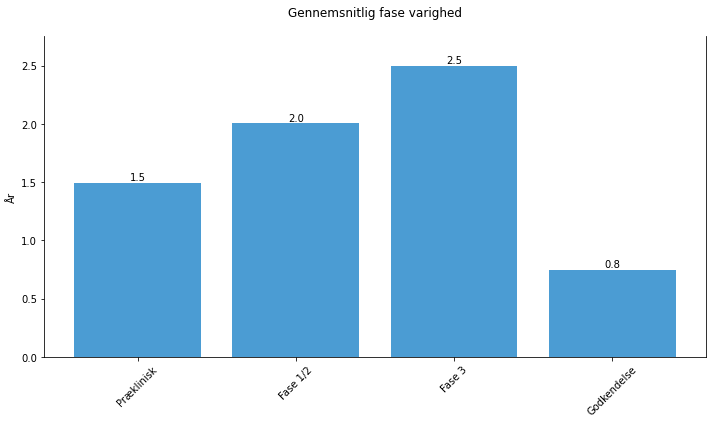

In [39]:
def plot_phase_breakdown(results):
    # Create output directory if it doesn't exist
    output_dir = './output'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    phases = ['Præklinisk', 'Fase 1/2', 'Fase 3', 'Godkendelse']
    durations = [np.mean([r['præklinisk_tid'] for r in results]),
                 np.mean([r['fase12_tid'] for r in results]),
                 np.mean([r['fase3_tid'] for r in results]),
                 np.mean([r['godkendelse_tid'] for r in results])]
    
    # Create figure with nice proportions and transparent background
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.patch.set_alpha(0.0)  # Make figure background transparent
    ax.patch.set_alpha(0.0)   # Make plot background transparent
    
    # Plot bars with a nice blue color
    bars = ax.bar(phases, durations, color='#4B9CD3')  # Professional blue color
    
    # Customize the plot
    ax.set_title('Gennemsnitlig fase varighed', pad=20)
    ax.set_ylabel('År')
    
    # Remove top spine
    ax.spines['top'].set_visible(False)
    
    # Set y-axis to start from 0
    ax.set_ylim(0, max(durations) * 1.1)  # Add 10% padding at top
    
    # Rotate x-axis labels
    plt.xticks(rotation=45)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom')
    
    plt.tight_layout()
    
    # Save the plot with transparent background to output folder
    plt.savefig(os.path.join(output_dir, 'phase_duration.png'), 
                dpi=300,
                bbox_inches='tight',
                transparent=True)
    
    plt.show()

plot_phase_breakdown(resultater)

In [ ]:

def generate_cash_flow(simulation_result):
    development_years = int(simulation_result['samlet_tid'])
    commercialization_years = 20
    total_years = development_years + commercialization_years
    
    cash_flow = np.zeros(total_years)
    cash_flow[:development_years] = -simulation_result['totale_omkostninger'] / development_years
    cash_flow[development_years:] = simulation_result['total_omsætning'] * 0.8 / commercialization_years
    
    return pd.Series(cash_flow)

def plot_cash_flow_projections(results, sample_size=100):
    sampled_results = results if len(results) <= sample_size else np.random.choice(results, sample_size, replace=False)
    cash_flows = pd.DataFrame([generate_cash_flow(r) for r in sampled_results])
    
    mean_cash_flow = cash_flows.mean()
    std_cash_flow = cash_flows.std()
    
    years = range(len(mean_cash_flow))
    plt.figure(figsize=(12, 6))
    plt.plot(years, mean_cash_flow, label='Mean Cash Flow')
    plt.fill_between(years, mean_cash_flow - std_cash_flow, mean_cash_flow + std_cash_flow, alpha=0.2)
    plt.title('Cash Flow Projections')
    plt.xlabel('Years')
    plt.ylabel('Cash Flow ($)')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.legend()
    plt.show()

def plot_npv_distribution(results):
    npvs = [r['godkendt_npv'] for r in results]
    
    plt.figure(figsize=(10, 6))
    plt.hist(npvs, bins=50, density=True, alpha=0.7)
    plt.title('NPV Distribution')
    plt.xlabel('NPV ($)')
    plt.ylabel('Density')
    plt.axvline(x=np.mean(npvs), color='r', linestyle='--', label='Mean NPV')
    plt.legend()
    plt.show()

def plot_cumulative_cash_flow(results, sample_size=100):
    sampled_results = results if len(results) <= sample_size else np.random.choice(results, sample_size, replace=False)
    cash_flows = pd.DataFrame([generate_cash_flow(r) for r in sampled_results])
    cumulative_cash_flows = cash_flows.cumsum()
    
    mean_cumulative = cumulative_cash_flows.mean()
    std_cumulative = cumulative_cash_flows.std()
    
    years = range(len(mean_cumulative))
    plt.figure(figsize=(12, 6))
    plt.plot(years, mean_cumulative, label='Mean Cumulative Cash Flow')
    plt.fill_between(years, mean_cumulative - std_cumulative, mean_cumulative + std_cumulative, alpha=0.2)
    plt.title('Cumulative Cash Flow')
    plt.xlabel('Years')
    plt.ylabel('Cumulative Cash Flow ($)')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.legend()
    plt.show()



# Assuming 'resultater' contains your simulation results
plot_cash_flow_projections(resultater)
plot_npv_distribution(resultater)
plot_cumulative_cash_flow(resultater)
plot_phase_breakdown(resultater)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import font_manager

# Add Helvetica Neue font
#font_path = "/path/to/HelveticaNeue.ttf"  # Update this path
#font_manager.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Helvetica Neue'

# Data
phases = ['Preclinical', 'Phase 1', 'Phase 2', 'Phase 3', 'Approved']
npv_values = [153.7, 194.0, 244.5, 312.2, 425.3]  # Values in millions

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8.6, 8.8), dpi=100)
fig.patch.set_facecolor('white')

# Plot the data
ax.plot(phases, npv_values, color='#0000FF', linewidth=2, marker='o', markersize=8)

# Add dollar amount labels (slightly to the left)
for i, v in enumerate(npv_values):
    ax.text(i-0.1, v, f'${v}M', ha='right', va='bottom', fontweight='bold', fontsize=10)

# Customize the plot
ax.set_ylabel('Risk-Adjusted NPV (USD Millions)', fontsize=12, color='#000000')
#ax.set_title('Risk-Adjusted NPV by Development Phase', fontsize=16, fontweight='bold', color='#000000')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Customize remaining spines
ax.spines['left'].set_color('#888888')
ax.spines['bottom'].set_color('#888888')

# Customize ticks
ax.tick_params(axis='both', colors='#888888', which='both', length=0)

# Remove gridlines
ax.grid(False)

# Adjust layout and save
plt.tight_layout()
plt.savefig('risk_adjusted_npv_graph_labeled_adjusted.png', dpi=100, bbox_inches='tight', pad_inches=0.1)
plt.close()

print("Updated Risk-Adjusted NPV graph with adjusted labels has been saved as 'risk_adjusted_npv_graph_labeled_adjusted.png'")